In [12]:
import pandas as pd

df=pd.read_csv("random_forest_tabular_data.csv")

In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [14]:
df.head()

,age,experience_years,education_level,hours_per_week,projects_completed,certifications,salary_lpa
0,56,12,1,40,19,2,8.272489
1,46,39,1,49,18,4,16.584269
2,32,1,0,43,18,8,8.780681
3,60,19,2,63,11,7,16.767576
4,25,0,0,61,36,1,5.133681


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 1000 non-null   int64  
 1   experience_years    1000 non-null   int64  
 2   education_level     1000 non-null   int64  
 3   hours_per_week      1000 non-null   int64  
 4   projects_completed  1000 non-null   int64  
 5   certifications      1000 non-null   int64  
 6   salary_lpa          1000 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 54.8 KB


In [16]:
df.describe()

,age,experience_years,education_level,hours_per_week,projects_completed,certifications,salary_lpa
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000
mean,40.986000,20.021000,1.506000,44.71400,24.91300,4.603000,13.600803
std,13.497852,11.601947,1.132805,14.31143,14.62475,2.851231,3.595712
min,18.000000,0.000000,0.000000,20.00000,0.00000,0.000000,3.122448
25%,29.000000,10.000000,0.000000,32.00000,12.00000,2.000000,11.239376
50%,42.000000,20.000000,1.000000,45.00000,25.00000,5.000000,13.689664
75%,52.000000,30.000000,3.000000,57.00000,38.00000,7.000000,16.102619
max,64.000000,39.000000,3.000000,69.00000,49.00000,9.000000,23.786607


In [17]:
X = df.drop("salary_lpa", axis=1)
y = df["salary_lpa"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [19]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

rf.fit(X_train, y_train)


,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [20]:
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

print("Train R²:", r2_score(y_train, train_pred))
print("Test  R²:", r2_score(y_test, test_pred))
print("OOB   R²:", rf.oob_score_)

Train R²: 0.9523503717582843
Test  R²: 0.6195688632719547
OOB   R²: 0.6478714581143505


In [21]:
rf_reg = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=5,     # ⭐ critical
    max_features=0.7,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

rf_reg.fit(X_train, y_train)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,0.7
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [22]:
print("Train R²:", r2_score(y_train, rf_reg.predict(X_train)))
print("Test  R²:", r2_score(y_test, rf_reg.predict(X_test)))
print("OOB   R²:", rf_reg.oob_score_)

Train R²: 0.8133508980863323
Test  R²: 0.6309431048866716
OOB   R²: 0.6543163794665717


In [23]:
importances = pd.Series(
    rf_reg.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances

experience_years      0.300849
education_level       0.252301
certifications        0.209987
age                   0.159072
projects_completed    0.042897
hours_per_week        0.034894
dtype: float64

In [24]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rf_reg,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importance = pd.Series(
    perm.importances_mean,
    index=X.columns
).sort_values(ascending=False)

perm_importance

education_level       0.426333
experience_years      0.379645
certifications        0.339613
age                   0.160169
projects_completed    0.013250
hours_per_week       -0.003774
dtype: float64

In [25]:
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, kept for consistency
    ("rf", RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

In [26]:
param_grid = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_leaf": [2, 5, 10],
    "rf__max_features": [0.5, 0.7, "sqrt"]
}

In [27]:
gs = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'rf__max_depth': [None, 10, ...], 'rf__max_features': [0.5, 0.7, ...], 'rf__min_samples_leaf': [2, 5, ...], 'rf__n_estimators': [200, 400]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [28]:
gs.best_params_

{'rf__max_depth': 10,
 'rf__max_features': 0.7,
 'rf__min_samples_leaf': 2,
 'rf__n_estimators': 200}

In [29]:
best_model = gs.best_estimator_

In [30]:
print("Final Test R²:", r2_score(y_test, best_model.predict(X_test)))

Final Test R²: 0.6291944715699581


In [31]:
residuals = y_test - best_model.predict(X_test)
residuals.describe()

count    200.000000
mean       0.188049
std        2.181239
min       -7.045199
25%       -1.155852
50%        0.266458
75%        1.574318
max        7.028568
Name: salary_lpa, dtype: float64

In [32]:
r2_score(y_train, best_model.predict(X_train)),
r2_score(y_test, best_model.predict(X_test))

0.6291944715699581

ValueError: x and y must be the same size

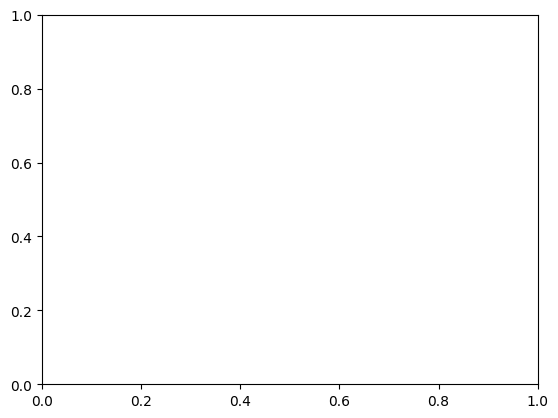

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_train)
plt.xlabel("Actual Salary (LPA)")
plt.ylabel("Predicted Salary (LPA)")
plt.title("Actual vs Predicted Salary (Random Forest)")
plt.show()

In [ ]:
residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0)
plt.xlabel("Predicted Salary (LPA)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.show()

In [ ]:
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values()

plt.figure()
importances.plot(kind="barh")
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()

In [ ]:
perm = permutation_importance(
    rf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importances = pd.Series(
    perm.importances_mean,
    index=X.columns
).sort_values()

plt.figure()
perm_importances.plot(kind="barh")
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance")
plt.show()

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    rf,
    X_train,
    features=["experience_years"]
)

plt.show()